# Load and Clean

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import re
from nltk.corpus import stopwords
nltk.download("stopwords")

data_text= pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
data_variants= pd.read_csv("training_variants")

stop_words = set(stopwords.words('english'))

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        total_text = re.sub('\s+',' ', total_text)
        total_text = total_text.lower()

        for word in total_text.split():
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)

data = pd.merge(data_variants, data_text,on='ID', how='left')

print(data.head())
print(data.shape)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [34]:
#Missing text values

data.loc[data['TEXT'].isnull(),'TEXT'] = data['Gene'] +' '+data['Variation']
print(data.loc[[1109,1277,1407,1639,2755],:])

        ID    Gene             Variation  Class                         TEXT
1109  1109   FANCA                S1088F      1                 FANCA S1088F
1277  1277  ARID5B  Truncating_Mutations      1  ARID5B Truncating Mutations
1407  1407   FGFR3                 K508M      6                  FGFR3 K508M
1639  1639    FLT1         Amplification      6           FLT1 Amplification
2755  2755    BRAF                 G596C      7                   BRAF G596C


# Data Split

In [38]:
#Breaking Data by maintaining the distribution of "Class"
from sklearn.model_selection import train_test_split 

y_true = data['Class'].values
data.Gene      = data.Gene.str.replace('\s+', '_')
data.Variation = data.Variation.str.replace('\s+', '_')

X_Dtrain, X_test, y_Dtrain, y_test= train_test_split(data, y_true, stratify=y_true, test_size=0.2)
X_train, X_cv, y_train, y_cv      = train_test_split(X_Dtrain, y_Dtrain, stratify=y_Dtrain, test_size=0.2)

print(X_train.shape,y_train.shape)
print(X_cv.shape,y_cv.shape)
print(X_test.shape,y_test.shape)

(2124, 5) (2124,)
(532, 5) (532,)
(665, 5) (665,)


# Normalization and Vectorization

In [46]:
#Featurizing gene and variation using one-hot encoding and text using tfidf

from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

gene_vectorizer= CountVectorizer()
gene_onehot_train= gene_vectorizer.fit_transform(X_train["Gene"])
gene_onehot_cv   = gene_vectorizer.transform(X_cv["Gene"])
gene_onehot_test = gene_vectorizer.transform(X_test["Gene"])


variation_vectorizer= CountVectorizer()
variation_onehot_train= variation_vectorizer.fit_transform(X_train["Variation"])
variation_onehot_cv   = variation_vectorizer.transform(X_cv["Variation"])
variation_onehot_test = variation_vectorizer.transform(X_test["Variation"])

text_vectorizer= TfidfVectorizer(min_df=3)
text_tfidf_train= normalize(text_vectorizer.fit_transform(X_train['TEXT']))
text_tfidf_cv   = normalize(text_vectorizer.transform(X_cv["TEXT"]))
text_tfidf_test = normalize(text_vectorizer.transform(X_test["TEXT"]))

print(gene_onehot_train.shape,"\n",gene_onehot_cv.shape,"\n",gene_onehot_test.shape) 
print(variation_onehot_train.shape,"\n",variation_onehot_cv.shape,"\n",variation_onehot_test.shape)
print(text_tfidf_train.shape,"\n",text_tfidf_cv.shape,"\n",text_tfidf_test.shape)

(2124, 230) 
 (532, 230) 
 (665, 230)
(2124, 1965) 
 (532, 1965) 
 (665, 1965)
(2124, 53046) 
 (532, 53046) 
 (665, 53046)


In [44]:
#Response Coding function

def gv_dictionary(feature,alpha):
    value_count= X_train[feature].value_counts()
    
    gv_dict= dict()
    
    for i,denominator in value_count.items():
        vec=[]
        for k in range(1,10):
            cls_cnt = X_train.loc[(X_train["Class"]==k) & (X_train[feature]==i)]
            vec.append((cls_cnt.shape[0] + alpha*10)/(denominator + alpha*90))
            
        gv_dict[i]=vec
        
    return gv_dict

def get_features(df,feature,alpha):
    gv_dict= gv_dictionary(feature,alpha)
    value_count= dict(X_train[feature].value_counts())
    
    gv_featurized=[]
    for index,row in df.iterrows():
        if(row[feature] in value_count.keys()):
            gv_featurized.append(gv_dict[row[feature]])
        else:
            gv_featurized.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    
    return gv_featurized

In [45]:
#Response Coding gene and variation

gene_response_train= np.array(get_features(X_train, "Gene", 1))
gene_response_cv   = np.array(get_features(X_cv, "Gene", 1))
gene_response_test = np.array(get_features(X_test, "Gene", 1))

variation_response_train= np.array(get_features(X_train, "Variation", 1))
variation_response_cv   = np.array(get_features(X_cv, "Variation", 1))
variation_response_test = np.array(get_features(X_test, "Variation", 1))

print(gene_response_train.shape,"\n",gene_response_cv.shape,"\n",gene_response_test.shape,"\n")
print(variation_response_train.shape,"\n",variation_response_cv.shape,"\n",variation_response_test.shape) 

(2124, 9) 
 (532, 9) 
 (665, 9) 

(2124, 9) 
 (532, 9) 
 (665, 9)


In [51]:
#Dictionary maker function
#Make a total dictionary and a list with dictionaries for each class

from collections import defaultdict

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

dict_list = []
for i in range(1,10):
    cls_text = X_train[X_train['Class']==i]
    dict_list.append(extract_dictionary_paddle(cls_text))
    
total_dict = extract_dictionary_paddle(X_train)

In [52]:
#Response Coding Function for text

import math

def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [79]:
#Response Coding of text

text_response_train= get_text_responsecoding(X_train)
text_response_test   = get_text_responsecoding(X_test)
text_response_cv = get_text_responsecoding(X_cv)

print(text_response_train.shape,"\n",text_response_cv.shape,"\n",text_response_test.shape)

(2124, 9) 
 (532, 9) 
 (665, 9)


In [80]:
#Normalize as probability

text_response_train= (text_response_train.T/text_response_train.sum(axis=1)).T
text_response_cv   = (text_response_cv.T/text_response_cv.sum(axis=1)).T
text_response_test = (text_response_test.T/text_response_test.sum(axis=1)).T

# Final Data

In [82]:
#Final Data for onehot and response coding
from scipy.sparse import hstack

train_gene_var_onehotCoding= hstack((gene_onehot_train,variation_onehot_train))
test_gene_var_onehotCoding = hstack((gene_onehot_test,variation_onehot_test))
cv_gene_var_onehotCoding   = hstack((gene_onehot_cv,variation_onehot_cv))

X_train_onehotCoding = hstack((train_gene_var_onehotCoding, text_tfidf_train)).tocsr()
y_train = np.array(list(X_train['Class']))

X_test_onehotCoding = hstack((test_gene_var_onehotCoding, text_tfidf_test)).tocsr()
y_test = np.array(list(X_test['Class']))

X_cv_onehotCoding = hstack((cv_gene_var_onehotCoding, text_tfidf_cv)).tocsr()
y_cv = np.array(list(X_cv['Class']))


train_gene_var_responseCoding= np.hstack((gene_response_train,variation_response_train))
test_gene_var_responseCoding = np.hstack((gene_response_test,variation_response_test))
cv_gene_var_responseCoding   = np.hstack((gene_response_cv,variation_response_cv))

X_train_responseCoding= np.hstack((train_gene_var_responseCoding, text_response_train))
X_test_responseCoding = np.hstack((test_gene_var_responseCoding, text_response_test))
X_cv_responseCoding   = np.hstack((cv_gene_var_responseCoding, text_response_cv))

print(X_train_onehotCoding.shape)
print(X_test_onehotCoding.shape)
print(X_cv_onehotCoding.shape)
print("-"*80)
print(X_train_responseCoding.shape,"\n")
print(X_test_responseCoding.shape,"\n")
print(X_cv_responseCoding.shape,"\n")

(2124, 55241)
(665, 55241)
(532, 55241)
--------------------------------------------------------------------------------
(2124, 27) 

(665, 27) 

(532, 27) 



# Model Building

In [108]:
#Building a confusion matrix plotter

from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.calibration import CalibratedClassifierCV

def plot_confusion_matrix(test_y,predicted_y):
    cnf_mat= confusion_matrix(test_y, predicted_y)
    pre_mat= ((cnf_mat.T)/(cnf_mat.sum(axis=1))).T
    rec_mat= cnf_mat/(cnf_mat.sum(axis=0))
    
    labels = [1,2,3,4,5,6,7,8,9]
    
    print("\n")
    print("-"*10, "Confusion matrix", "-"*10)
    plt.figure(figsize=(21,7))
    sns.heatmap(cnf_mat, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("\n")
    print("-"*10, "Precision matrix", "-"*10)
    plt.figure(figsize=(21,7))
    sns.heatmap(pre_mat, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("\n")
    print("-"*10, "Recall matrix", "-"*10)
    plt.figure(figsize=(21,7))
    sns.heatmap(rec_mat, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    print("Log loss for train Data: ",log_loss(train_y,sig_clf.predict_proba(train_x)))
    print("Log loss for Test Data:",log_loss(test_y, sig_clf.predict_proba(test_x)))
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    
    plot_confusion_matrix(test_y, pred_y)    


Optimal value of alpha: 0.01
CV Log loss for this alpha: 1.1383948967604725


--------------------Final Model ON TEST DATA-------------------- 

Log loss for train Data:  0.6500521198441579
Log loss for Test Data: 1.1310048362806733
Number of mis-classified points : 0.33383458646616543


---------- Confusion matrix ----------


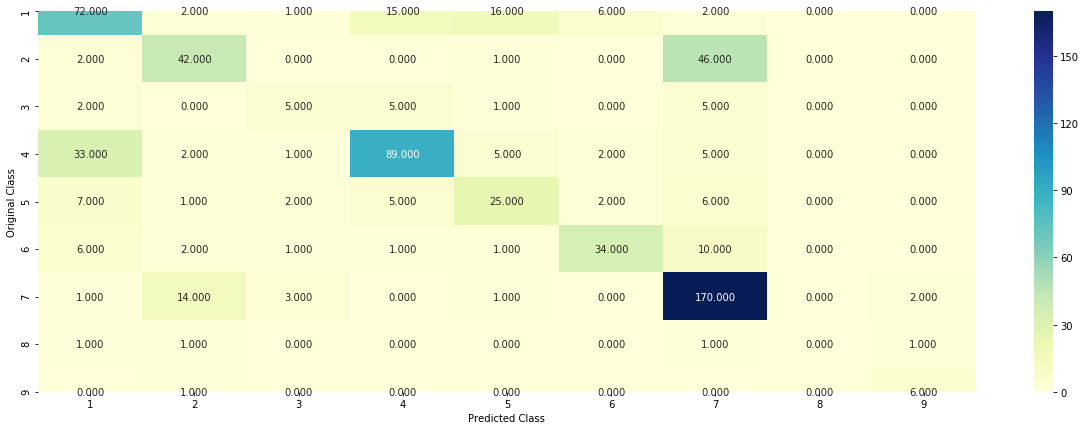



---------- Precision matrix ----------


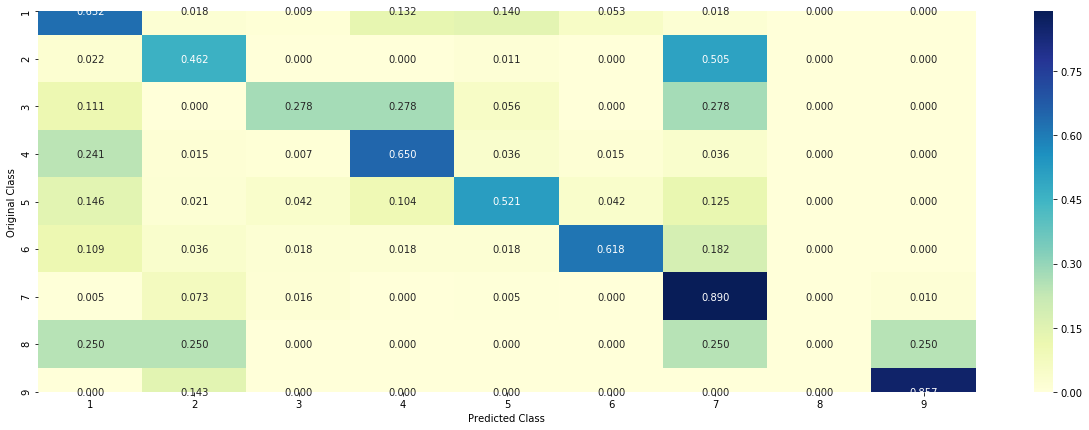



---------- Recall matrix ----------


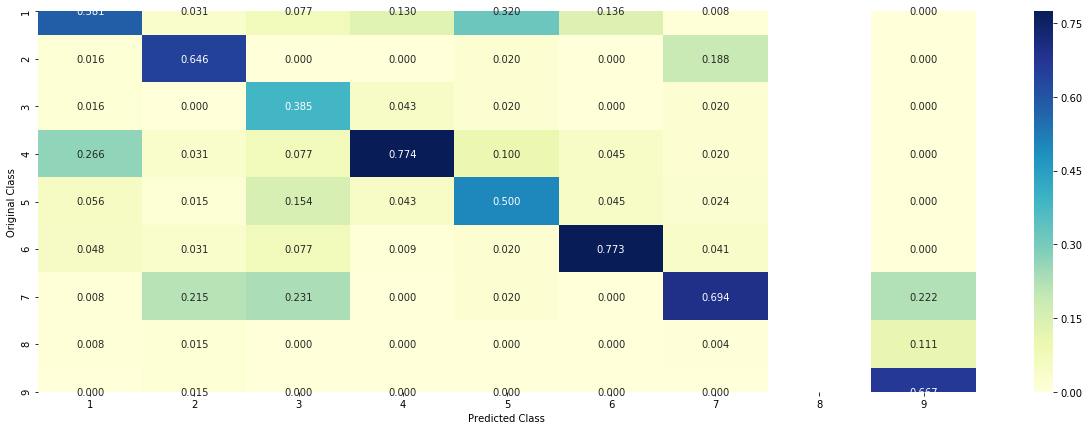

In [109]:
#Naive Bayes Model on Onehot Encoded Features

import warnings
from sklearn.naive_bayes import MultinomialNB
warnings.filterwarnings("ignore")

alpha_values=[0.0001, 0.001, 0.01, 0.05 ,0.1, 1, 10, 100,1000]
cv_logloss=[]

for alpha in alpha_values:
    clf= MultinomialNB(alpha=alpha)
    clf.fit(X_train_onehotCoding,y_train)
    sig_clf= CalibratedClassifierCV(clf, method="sigmoid",cv=None)
    sig_clf.fit(X_train_onehotCoding,y_train)
    
    sig_clf_probs = sig_clf.predict_proba(X_cv_onehotCoding)
    loss_cv= log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15)
    cv_logloss.append(loss_cv)

min_loss=cv_logloss[0]
i=0
max_i=0
for loss in cv_logloss:
    if(loss<min_loss):
        min_loss=loss
        max_i=i
    i=i+1
    
optimal_alpha=alpha_values[max_i]
print("Optimal value of alpha: "+str(optimal_alpha))
print("CV Log loss for this alpha: "+str(min_loss))
print("\n")

#Final Model
print("-"*20+"Final Model ON TEST DATA"+"-"*20,"\n")
NB_model= MultinomialNB(alpha=optimal_alpha)
predict_and_plot_confusion_matrix(X_train_onehotCoding, y_train, X_test_onehotCoding, y_test, NB_model)

Optimal value of alpha: 0.0001
CV Log loss for this alpha: 0.9303617706653151


--------------------Final Model ON TEST DATA-------------------- 

Log loss for train Data:  0.431862373089556
Log loss for Test Data: 0.9764465355314619
Number of mis-classified points : 0.3308270676691729


---------- Confusion matrix ----------


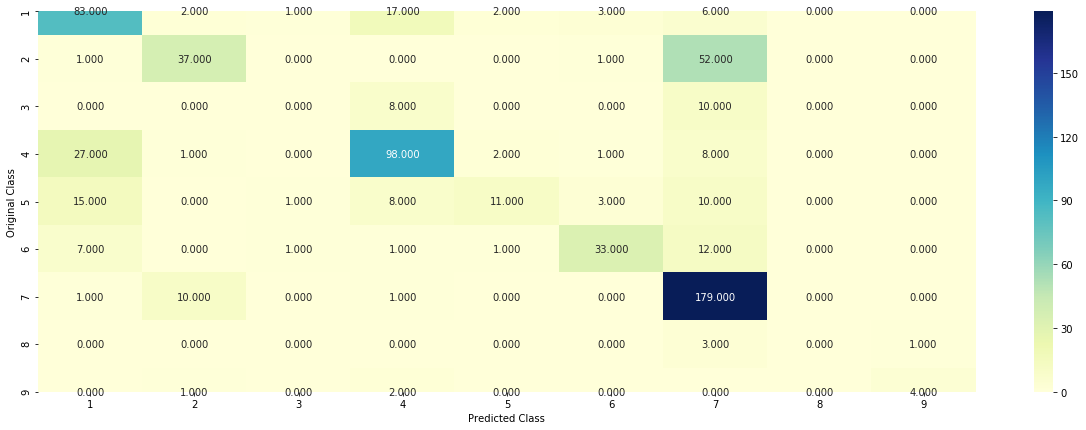



---------- Precision matrix ----------


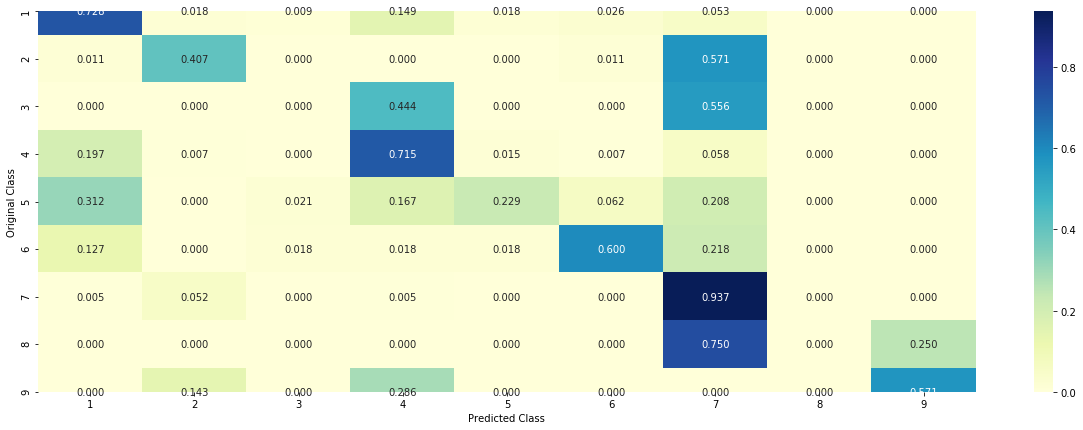



---------- Recall matrix ----------


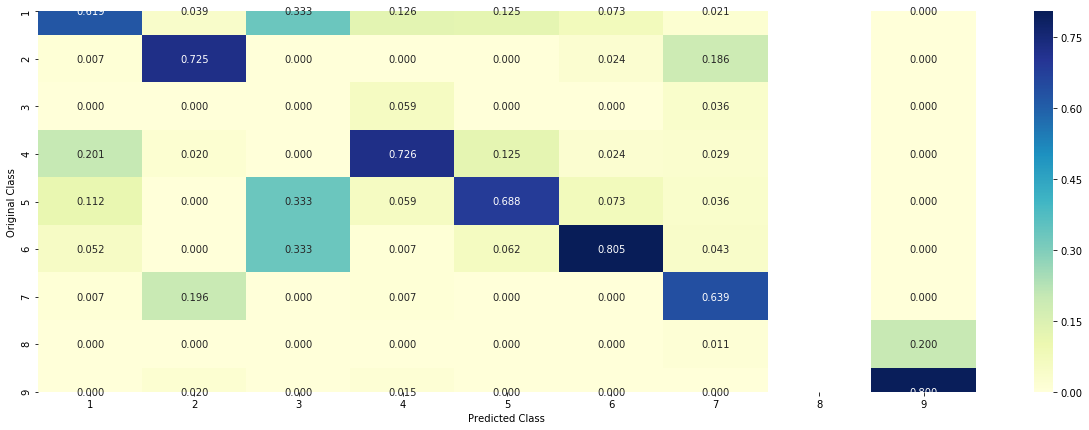

In [111]:
#Logostic Regresion with onehot Encoding and class balancing

from sklearn.linear_model import SGDClassifier

alpha_values=[10 ** x for x in range(-6, 3)]
cv_logloss=[]

for alpha in alpha_values:
    clf= SGDClassifier(alpha=alpha, class_weight="balanced", penalty="l2", loss="log", random_state=42)
    clf.fit(X_train_onehotCoding, y_train)
    sig_clf= CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_onehotCoding, y_train)
    
    sig_clf_probs = sig_clf.predict_proba(X_cv_onehotCoding)
    loss_cv= log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15)
    cv_logloss.append(loss_cv)

min_loss=cv_logloss[0]
i=0
max_i=0
for loss in cv_logloss:
    if(loss<min_loss):
        min_loss=loss
        max_i=i
    i=i+1
    
optimal_alpha=alpha_values[max_i]
print("Optimal value of alpha: "+str(optimal_alpha))
print("CV Log loss for this alpha: "+str(min_loss))
print("\n")

#Final Model
print("-"*20+"Final Model ON TEST DATA"+"-"*20,"\n")
LR_model= SGDClassifier(alpha=optimal_alpha, class_weight="balanced", penalty="l2", loss="log", random_state=42)
predict_and_plot_confusion_matrix(X_train_onehotCoding, y_train, X_test_onehotCoding, y_test, LR_model)


Optimal value of k: 15
CV Log loss for this k: 0.9730580172656701


--------------------Final Model ON TEST DATA-------------------- 

Log loss for train Data:  0.18491318406296947
Log loss for Test Data: 0.9950841537809172
Number of mis-classified points : 0.3533834586466165


---------- Confusion matrix ----------


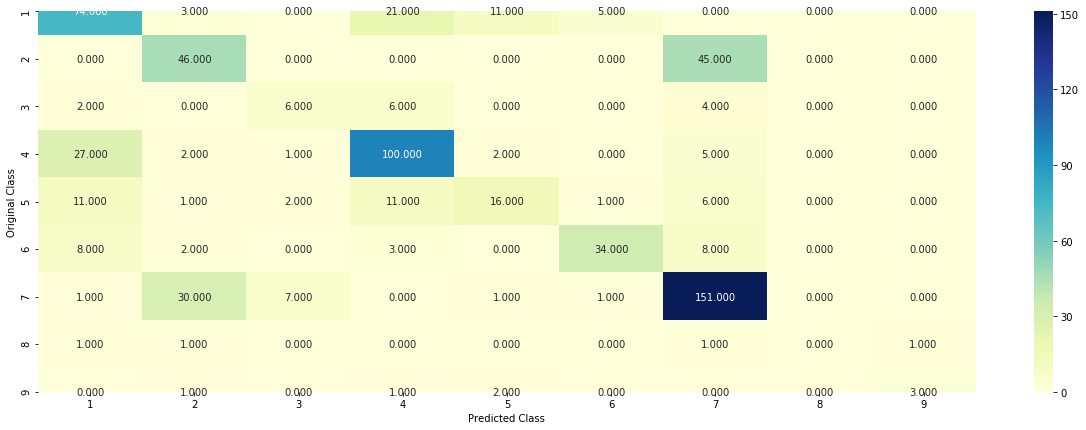



---------- Precision matrix ----------


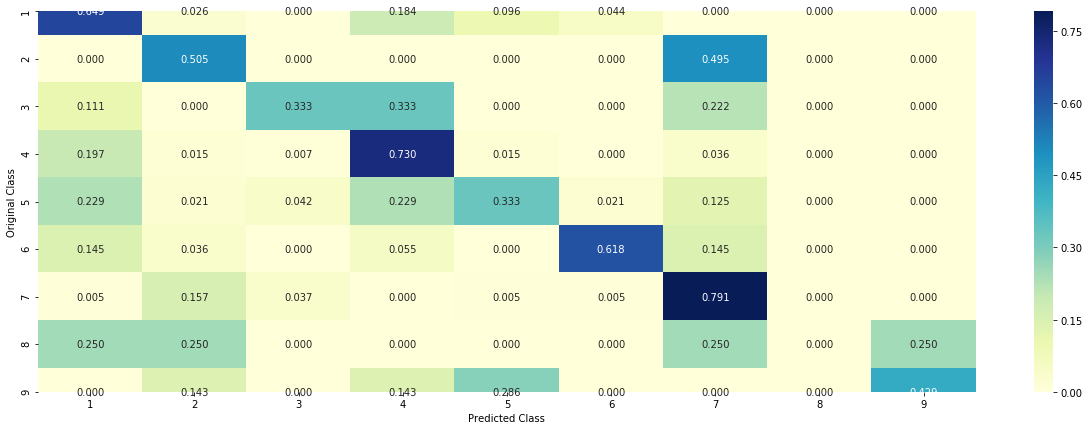



---------- Recall matrix ----------


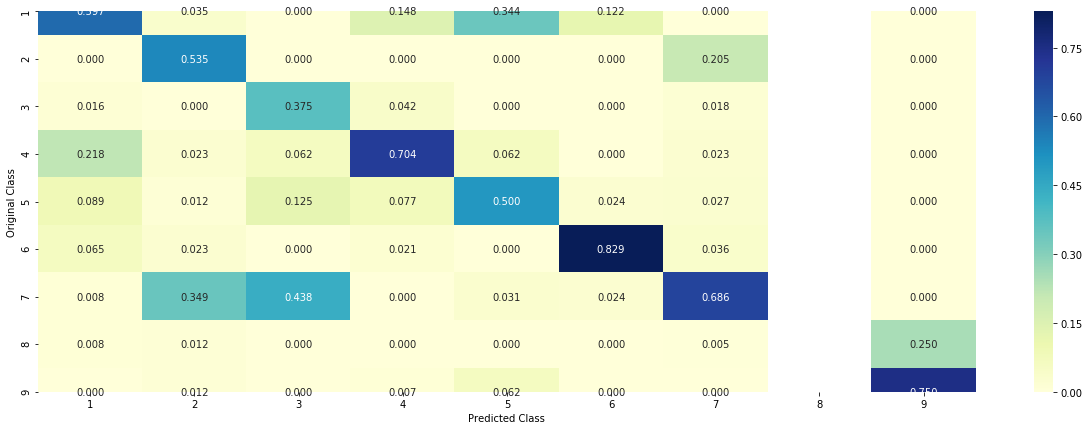

In [114]:
#KNN using response coding features

from sklearn.neighbors import KNeighborsClassifier

k_values=[5, 11, 15, 17 , 20, 31, 41, 51, 99]
cv_logloss=[]

for k in k_values:
    clf= KNeighborsClassifier(n_neighbors=k, weights="distance")
    clf.fit(X_train_responseCoding, y_train)
    sig_clf= CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_responseCoding, y_train)
    
    sig_clf_probs = sig_clf.predict_proba(X_cv_responseCoding)
    loss_cv= log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15)
    cv_logloss.append(loss_cv)

min_loss=cv_logloss[0]
i=0
max_i=0
for loss in cv_logloss:
    if(loss<min_loss):
        min_loss=loss
        max_i=i
    i=i+1
    
optimal_k=k_values[max_i]
print("Optimal value of k: "+str(optimal_k))
print("CV Log loss for this k: "+str(min_loss))
print("\n")

#Final Model
print("-"*20+"Final Model ON TEST DATA"+"-"*20,"\n")
KNN_model= KNeighborsClassifier(n_neighbors=optimal_k, weights="distance")
predict_and_plot_confusion_matrix(X_train_responseCoding, y_train, X_test_responseCoding, y_test, KNN_model)